## Let's do a thing

In [1]:
from PIL import Image
from shapely.geometry import Polygon, Point, shape
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import geopandas as gpd

## Adorable golden retriever incoming...

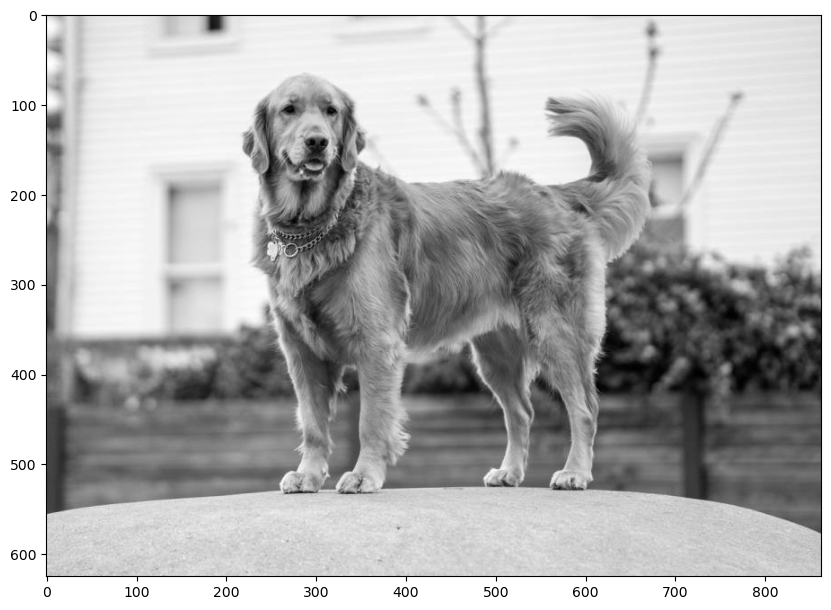

In [2]:
image = Image.open('retriever.jpeg').convert('L')

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(image, cmap='binary_r')

## Generate some completely random data as if we're doing object detection on this golden retriever...

<AxesSubplot:>

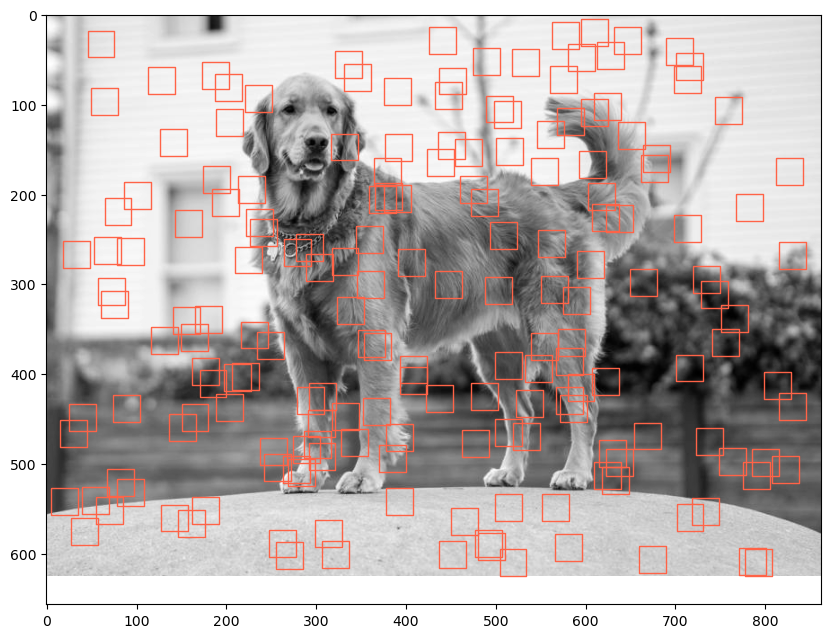

In [3]:
# Create a large polygon from the given bounds
large_polygon = Polygon.from_bounds(0, 0, image.width, image.height)

# Define the width and height of the smaller polygons
small_width = 30
small_height = 30

# Define the number of smaller polygons to create
num_polygons = 180

# Create a list to store the smaller polygons
small_polygons = []

# Loop through each smaller polygon to create it at a random location within the large polygon
for i in range(num_polygons):
    # Generate a random point within the bounds of the large polygon
    x = random.uniform(large_polygon.bounds[0], large_polygon.bounds[2] - small_width)
    y = random.uniform(large_polygon.bounds[1], large_polygon.bounds[3] - small_height)
    point = Point(x, y)
    
    # Check if the point is within the large polygon
    if large_polygon.contains(point):
        # If so, create a smaller polygon at the point
        small_polygon = Polygon([(x, y), (x + small_width, y), (x + small_width, y + small_height), (x, y + small_height)])
        
        # Add the smaller polygon to the list
        small_polygons.append(small_polygon)

image_bounds = gpd.GeoDataFrame(geometry=[large_polygon])
boxes = gpd.GeoDataFrame(geometry=small_polygons)

fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.imshow(image, cmap='binary_r')
boxes.boundary.plot(ax=ax, color='tomato', linewidth=1)

## Make some functions to do stuff... there must be better funcitons somewhere but these are fine

In [4]:
def generate_image_tiles(image_name, image, step: int = 256, overlap: int = 20):

    width = image.width
    height = image.height

    # Calculate the number of steps needed to cover the entire width and height
    num_x_steps = int(np.ceil(width / (step - overlap)))
    num_y_steps = int(np.ceil(height / (step - overlap)))

    # Create an array of start points for each x and y step
    x_starts = np.arange(num_x_steps) * (step - overlap)
    y_starts = np.arange(num_y_steps) * (step - overlap)

    # Create an array of end points for each x and y step
    x_ends = np.minimum(x_starts + step, width)
    y_ends = np.minimum(y_starts + step, height)

    # Filter out the ranges that are not exactly 256 units long
    x_ranges = np.vstack((x_starts, x_ends)).T
    x_ranges = x_ranges[x_ranges[:, 1] - x_ranges[:, 0] == step]

    y_ranges = np.vstack((y_starts, y_ends)).T
    y_ranges = y_ranges[y_ranges[:, 1] - y_ranges[:, 0] == step]

    # Create a meshgrid of the x and y ranges
    x_mesh, y_mesh = np.meshgrid(x_ranges[:, 0], y_ranges[:, 0])

    # Combine the x and y meshgrids into a single array of ranges
    ranges = np.vstack((x_mesh.flatten(), y_mesh.flatten(), x_mesh.flatten() + step, y_mesh.flatten() + step)).T

    image_tiles = []
    image_tile_polygons = []
    image_tile_names = []
    
    for x1, y1, x2, y2 in ranges:
        tile = image.crop([x1, y1, x2, y2])
        tile_polygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
        tile_name = f'{image_name}_{x1}_{y1}_{x2}_{y2}'

        image_tiles.append(tile)
        image_tile_polygons.append(tile_polygon)
        image_tile_names.append(tile_name)
        tile.save(tile_name + '.png')

    return gpd.GeoDataFrame(index=image_tile_names, geometry=image_tile_polygons), image_tiles

def generate_label_tiles(tiles: gpd.GeoDataFrame, labels: gpd.GeoDataFrame, pct_area_within: int = 50):

    translated_labels = []
    for tile in tiles.iterfeatures():

        tile_id = tile['id']
        tile_geom = shape(tile['geometry'])
        chip = gpd.GeoDataFrame(geometry=[tile_geom])

        # Find all labels with more than 20%
        intersection = gpd.overlay(boxes, chip, how='intersection')
        intersection['percent_area'] = intersection.area / boxes.area * 100
        intersection = intersection.loc[intersection['percent_area']>pct_area_within]

        # Calculate the x and y offsets needed to shift the first polygon to (0,0)
        x_offset = -tile_geom.bounds[0]
        y_offset = -tile_geom.bounds[1]

        # Shift all polygons in the geoseries by the same amount
        chip_shift = chip.translate(x_offset, y_offset)
        intersection_shift = intersection.translate(x_offset, y_offset)

        # If there was no intersection we still want a label
        if intersection_shift.empty:
            intersection_shift = [None]

        # Fill out a dataframe with the label information
        intersection_df = pd.DataFrame()
        intersection_df['geometry'] = list(intersection_shift)
        intersection_df['image_id'] = tile_id
        intersection_df['label'] = 'thing_to_detect'

        translated_labels.append(intersection_df)

    df = pd.concat(translated_labels)
    return gpd.GeoDataFrame(df, geometry='geometry')

## Pick our tile size and overlap

In [5]:
step = 256
overlap = 20

tiles, images = generate_image_tiles(image_name='retriever', image=image, step=step, overlap=overlap)
labels = generate_label_tiles(tiles=tiles, labels=boxes)

In [6]:
tiles.head(10)

,geometry
retriever_0_0_256_256,"POLYGON ((0.000 0.000, 256.000 0.000, 256.000 ..."
retriever_236_0_492_256,"POLYGON ((236.000 0.000, 492.000 0.000, 492.00..."
retriever_472_0_728_256,"POLYGON ((472.000 0.000, 728.000 0.000, 728.00..."
retriever_0_236_256_492,"POLYGON ((0.000 236.000, 256.000 236.000, 256...."
retriever_236_236_492_492,"POLYGON ((236.000 236.000, 492.000 236.000, 49..."
retriever_472_236_728_492,"POLYGON ((472.000 236.000, 728.000 236.000, 72..."


In [7]:
labels.head(10)

,geometry,image_id,label
0,"POLYGON ((212.508 209.074, 242.508 209.074, 24...",retriever_0_0_256_256,thing_to_detect
1,"POLYGON ((186.942 95.922, 216.942 95.922, 216....",retriever_0_0_256_256,thing_to_detect
2,"POLYGON ((183.946 223.284, 213.946 223.284, 21...",retriever_0_0_256_256,thing_to_detect
3,"POLYGON ((64.305 234.067, 94.305 234.067, 94.3...",retriever_0_0_256_256,thing_to_detect
4,"POLYGON ((173.141 82.590, 203.141 82.590, 203....",retriever_0_0_256_256,thing_to_detect
5,"POLYGON ((48.943 111.134, 78.943 111.134, 78.9...",retriever_0_0_256_256,thing_to_detect
6,"POLYGON ((126.225 156.506, 156.225 156.506, 15...",retriever_0_0_256_256,thing_to_detect
7,"POLYGON ((220.770 107.564, 250.770 107.564, 25...",retriever_0_0_256_256,thing_to_detect
8,"POLYGON ((112.869 88.389, 142.869 88.389, 142....",retriever_0_0_256_256,thing_to_detect
9,"POLYGON ((45.376 47.304, 75.376 47.304, 75.376...",retriever_0_0_256_256,thing_to_detect


## Plot the result so we know we didn't mess up...

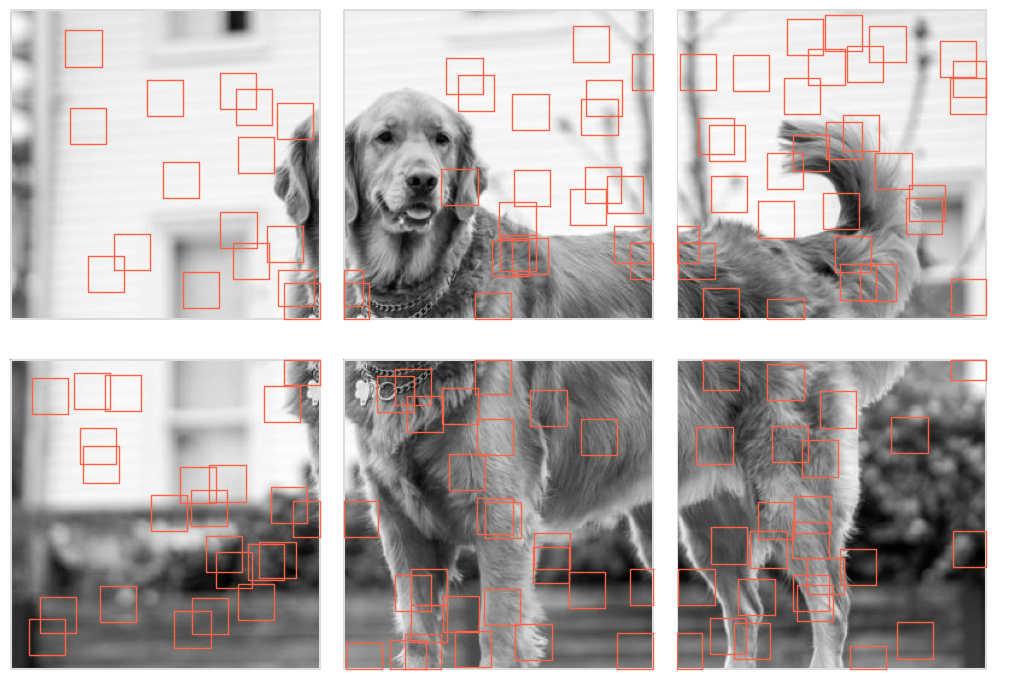

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7), layout='constrained')
for ax, img_id, img in zip(axs.flat, list(labels.image_id.unique()), images):
    ax.imshow(img, cmap='binary_r')
    gpd.GeoSeries(Polygon.from_bounds(0,0,step,step)).boundary.plot(ax=ax, color='gainsboro')
    labels[labels['image_id']==img_id].boundary.plot(ax=ax, color='tomato', linewidth=1)
    ax.axis('off')